In [92]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt
import numpy as np
import random
import glob

In [93]:
# Chemin vers les fichiers CSV
chemin = '/Users/melusinecaillard/Desktop/players/*.csv'

# Liste des noms de fichiers
fichiers = glob.glob(chemin)

# Initialisation d'une liste pour stocker les DataFrames de chaque fichier
dfs = []
# Liste des encodages à essayer
encodings_to_try = [ 'utf-8','ISO-8859-1']

# Charger et concaténer les fichiers
for fichier in fichiers:
    df = None
    # Essayer différents encodages jusqu'à ce que la lecture réussisse
    for encoding in encodings_to_try:
        try:
            df = pd.read_csv(fichier, encoding=encoding)
            print(f"Lecture réussie avec l'encodage {encoding}.")
            break  # Sortir de la boucle si la lecture réussit avec un encodage
        except UnicodeDecodeError:
            print(f"Échec de la lecture avec l'encodage {encoding}. Essayer un autre encodage.")

    if df is not None:
        # Ajouter une colonne 'source' pour identifier la provenance de chaque fichier
        nom_fichier = fichier.split('/')[-1]
        saison = nom_fichier.split('.')[0].split('-')
        df['source'] = f"{saison[0]}-{saison[1]}"
        # Concaténer 'first_name' et 'second_name' en une seule colonne 'name'
        df['name'] = df['first_name'] + ' ' + df['second_name']
        # Supprimer les colonnes 'first_name' et 'second_name'
        df = df.drop(columns=['first_name', 'second_name'])
        # Ajouter le DataFrame à la liste
        dfs.append(df)
    else:
        print("Échec de la lecture du fichier:", fichier)


# Concaténer tous les DataFrames en un seul
data = pd.concat(dfs, ignore_index=True)



# Maintenant vous pouvez faire du traitement de données sur le DataFrame 'data'
# Par exemple, afficher les premières lignes
print(data.info())


Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Échec de la lecture avec l'encodage utf-8. Essayer un autre encodage.
Lecture réussie avec l'encodage ISO-8859-1.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
Lecture réussie avec l'encodage utf-8.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   goals_scored         5606 non-null   int64  
 1   assists              5606 non-null   int64  
 2   total_points         5606 non-null   int64  
 3   minutes              5606 non-null   int64  
 4   goals_conceded       5606 non-null   int64  
 5   creativity           5606 non-null   float64
 6   influence            5606 non-null   float64
 7   threat               5606 non-null   float64
 8   b

In [94]:
# Ingénierie des caractéristiques
selected_features = ['goals_scored','assists','goals_conceded','creativity','influence','threat','bonus','clean_sheets','red_cards','yellow_cards','now_cost']
X = data[selected_features]
y = data['total_points']

In [95]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
# Sélectionner uniquement les colonnes numériques
numeric_columns = X_train.select_dtypes(include=['number']).columns

In [97]:
# Vérification des valeurs manquantes dans les données d'entraînement
print("Valeurs manquantes dans y_train:", np.isnan(y_train).sum())

# Vérification des valeurs manquantes dans les données de test
print("Valeurs manquantes dans y_test:", np.isnan(y_test).sum())


Valeurs manquantes dans y_train: 0
Valeurs manquantes dans y_test: 0


In [98]:
# Définir les hyperparamètres à optimiser
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'l2_regularization': [0.0, 0.1, 0.2]
}


In [99]:
# Create the HistGradientBoostingRegressor model
model = HistGradientBoostingRegressor()

In [100]:
# Train the model
model.fit(X_train, y_train)


HistGradientBoostingRegressor()

In [101]:
# Predict on the test set
y_pred = model.predict(X_test)

In [102]:
# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


Evaluation des performances du modèle

In [103]:
# Effectuer la validation croisée
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')


In [104]:
# Exécuter la recherche par grille sur les données
grid_search.fit(X, y)


KeyboardInterrupt



In [105]:
# Calcul des métriques d'évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# Calculer la moyenne des scores de MSE
avg_mse = -scores.mean()

In [106]:
# Afficher les meilleurs paramètres et la meilleure MSE
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure MSE:", -grid_search.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [107]:
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Mean Absolute Error:", mae)

# Afficher le score moyen de MSE
print("Moyenne des scores de MSE:", avg_mse)

Mean Squared Error: 33.03430553567649
R-squared: 0.9857973698022744
Mean Absolute Error: 3.469018531795853
Moyenne des scores de MSE: 38.69325786657404


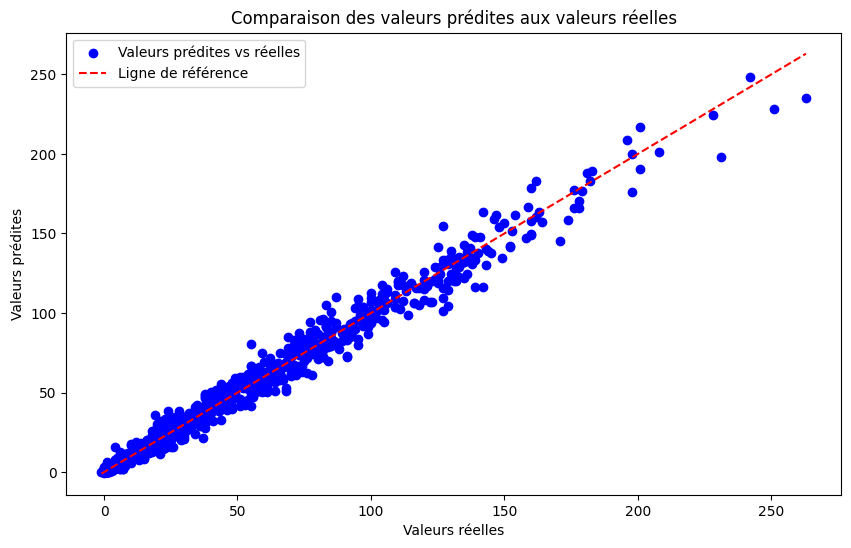

In [108]:
# Tracer les valeurs réelles par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Valeurs prédites vs réelles')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ligne de référence')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison des valeurs prédites aux valeurs réelles')
plt.legend()
plt.show()

In [145]:
# Créer un nouveau modèle avec les paramètres optimisés
optimal_model = HistGradientBoostingRegressor(
    l2_regularization=0.0,
    learning_rate=0.1,
    max_depth=5,
    max_iter=300,
    min_samples_leaf=2
)


In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_learning_curve_r2(estimator, X_train, y_train, X_test, y_test):
    train_r2 = []
    test_r2 = []

    for y_pred_train, y_pred_test in zip(estimator.staged_predict(X_train), estimator.staged_predict(X_test)):
        train_r2.append(r2_score(y_train, y_pred_train))
        test_r2.append(r2_score(y_test, y_pred_test))

    plt.plot(train_r2, label='Train R²')
    plt.plot(test_r2, label='Test R²')
    plt.xlabel('Number of Trees')
    plt.ylabel('R² Score')
    plt.title('Learning Curve (R²)')
    plt.legend()
    plt.show()

In [161]:
def plot_learning_curve_metrics(estimator, X_train, y_train, X_test, y_test):
    train_mse = []
    test_mse = []
    train_mae = []
    test_mae = []

    for y_pred_train, y_pred_test in zip(estimator.staged_predict(X_train), estimator.staged_predict(X_test)):
        train_mse.append(mean_squared_error(y_train, y_pred_train))
        test_mse.append(mean_squared_error(y_test, y_pred_test))
        train_mae.append(mean_absolute_error(y_train, y_pred_train))
        test_mae.append(mean_absolute_error(y_test, y_pred_test))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_mse, label='Train MSE')
    plt.plot(test_mse, label='Test MSE')
    plt.xlabel('Number of Trees')
    plt.ylabel('MSE')
    plt.title('Learning Curve (MSE)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_mae, label='Train MAE')
    plt.plot(test_mae, label='Test MAE')
    plt.xlabel('Number of Trees')
    plt.ylabel('MAE')
    plt.title('Learning Curve (MAE)')
    plt.legend()

    plt.tight_layout()
    plt.show()

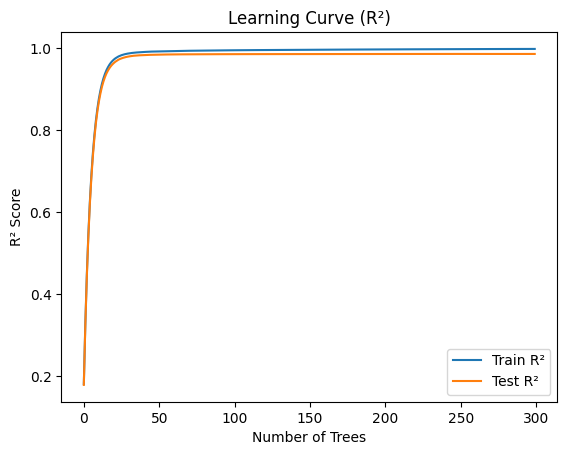

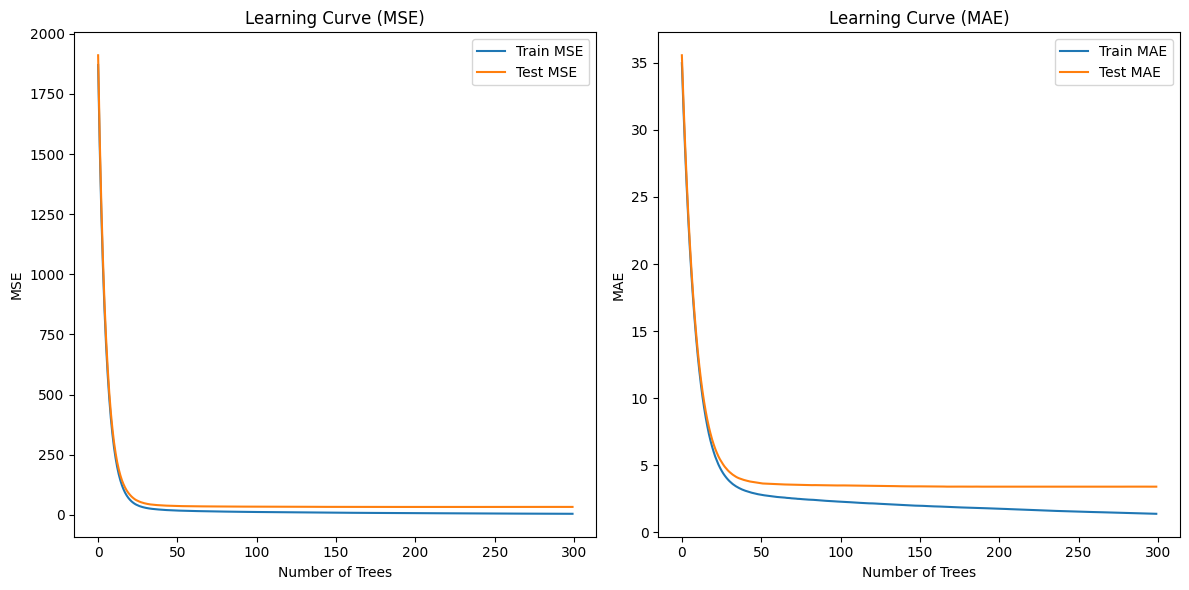

In [162]:
# Entraîner le nouveau modèle avec les données d'entraînement
optimal_model.fit(X_train, y_train)
plot_learning_curve_r2(optimal_model, X_train, y_train, X_test, y_test)
plot_learning_curve_metrics(optimal_model, X_train, y_train, X_test, y_test)


In [151]:
# Prédire sur les données de test
y_pred_optimal = optimal_model.predict(X_test)

In [152]:
# Calculer le RMSE
rmse_optimal = np.sqrt(mean_squared_error(y_test, y_pred_optimal))

# Calculer le MAPE
# Calculer le MAPE en évitant les divisions par zéro
mape_optimal = np.mean(np.abs((y_test - y_pred_optimal) / y_test.replace(0, np.nan))) * 100


In [153]:
# Évaluer les performances du nouveau modèle sur les données de test
mse_optimal = mean_squared_error(y_test, y_pred_optimal)
r2_optimal = r2_score(y_test, y_pred_optimal)
mae_optimal = mean_absolute_error(y_test, y_pred_optimal)

In [154]:

# Afficher les performances du nouveau modèle
print("Performances du modèle avec les paramètres optimisés :")
print("MSE:", mse_optimal)
print("R-squared:", r2_optimal)
print("MAE:", mae_optimal)
print("RMSE:", rmse_optimal)
print("MAPE:", mape_optimal)

Performances du modèle avec les paramètres optimisés :
MSE: 33.04935294037537
R-squared: 0.9857909003844705
MAE: 3.4067805653356045
RMSE: 5.748856663752835
MAPE: 20.410655950494


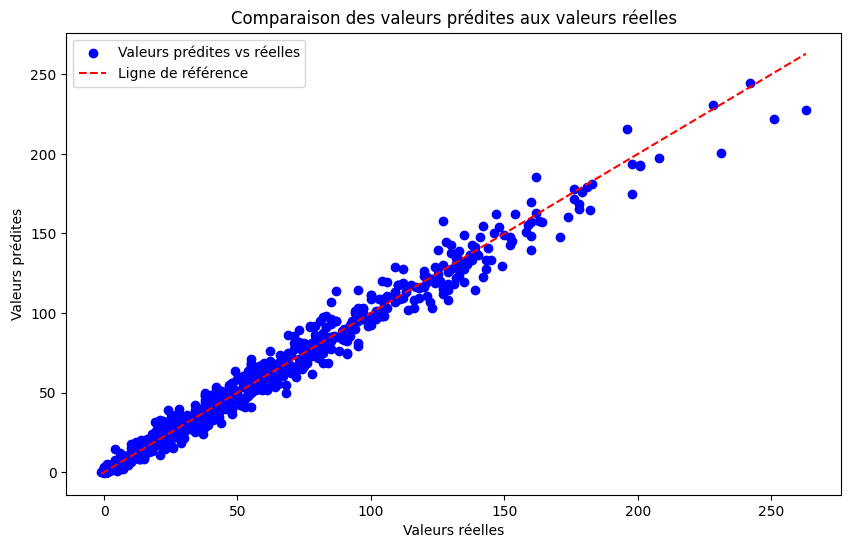

In [155]:
# Tracer les valeurs réelles par rapport aux valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimal, color='blue', label='Valeurs prédites vs réelles')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ligne de référence')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Comparaison des valeurs prédites aux valeurs réelles')
plt.legend()
plt.show()

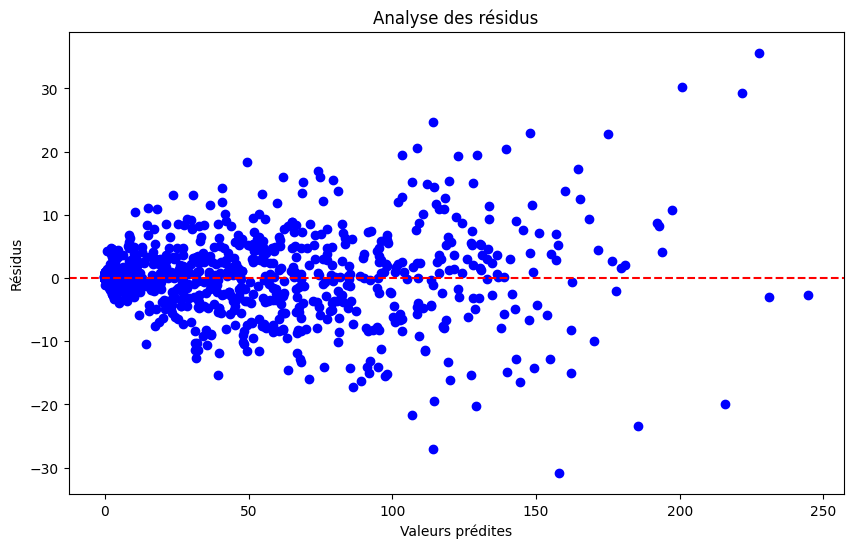

In [159]:
# Calculer les résidus
residuals = y_test - y_pred_optimal

# Tracer les résidus
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_optimal, residuals, color='blue')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Analyse des résidus')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


les résidus sont distribués de manière aléatoire, cela indique que le modèle ne présente pas de biais systématique dans ses prédictions.

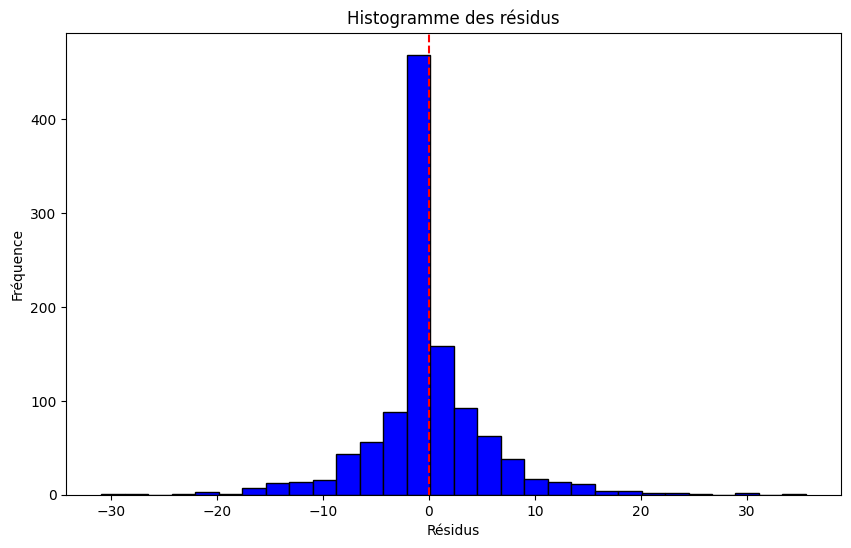

In [160]:
# Tracer l'histogramme des résidus
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Histogramme des résidus')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()


In [ ]:
print(data.head())

In [ ]:
"""
team_data = pd.read_csv('/Users/melusinecaillard/RSPL/data/2023-''''24/gws/gw16.csv')
team_data = team_data.rename(columns={'value': 'now_cost'})

print(team_data.head())
print(len(team_data))
"""

In [1]:
import pandas as pd
import boto3
import json

# Charger les informations d'identification à partir du fichier de configuration
with open('config.json') as f:
    config = json.load(f)

aws_access_key_id = config['AWS_ACCESS_KEY_ID']
aws_secret_access_key = config['AWS_SECRET_ACCESS_KEY']


#Créer une connexion S3 en utilisant les variables d'environnement
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

# Nom du bucket S3
bucket_name = 'myfplbucket1'

# Préfixe du dossier dans S3 où se trouvent les fichiers gw
dossier_prefix = 'data/2023-24/gws/'

# Rechercher le fichier gw le plus récent
fichier_gw_recent = None
dernier_num_gw = 0

for num_gw in range(1, 39):
    nom_fichier_s3 = f'{dossier_prefix}gw{num_gw}.csv'
    try:
        s3.head_object(Bucket=bucket_name, Key=nom_fichier_s3)
        dernier_num_gw = num_gw
    except Exception as e:
        # Le fichier n'existe pas, passer au suivant
        pass
print(dernier_num_gw)
# Si aucun fichier gw n'a été trouvé, sortir
if dernier_num_gw == 0:
    print("Aucun fichier gw trouvé dans le dossier.")
    exit()

# Télécharger le fichier gw le plus récent
nom_fichier_s3_recent = f'{dossier_prefix}gw{dernier_num_gw}.csv'
chemin_local_recent = f'../data/2023-24/gws/gw{dernier_num_gw}.csv'
s3.download_file(bucket_name, nom_fichier_s3_recent, chemin_local_recent)

# Lire le fichier CSV avec pandas
team_data = pd.read_csv(chemin_local_recent)
team_data = team_data.rename(columns={'value': 'now_cost'})

# Afficher les premières lignes du DataFrame pour vérifier si le fichier a été correctement lu
print(team_data.head())

ModuleNotFoundError: No module named 'pandas'

In [119]:
def predict_player_performance(model, player_name, data):
    # Filtrer les données pour obtenir les caractéristiques du joueur spécifié
    player_data = data[data['name'] == player_name]

    # Sélectionner uniquement les caractéristiques utilisées lors de l'entraînement
    selected_features = ['goals_scored','assists','goals_conceded','creativity','influence','threat','bonus','clean_sheets','red_cards','yellow_cards','now_cost']


    player_data = player_data[selected_features]

    # Effectuer la prédiction
    predicted_performance = optimal_model.predict(player_data)

    # Calculer la moyenne des performances prédites
    average_performance = np.mean(predicted_performance)

    return average_performance

In [120]:
# Nom du joueur à prédire
player_name = 'Erling Haaland'

# Prédiction des performances du joueur
predicted_performance = predict_player_performance(optimal_model, player_name, team_data)

print("Performances prédites (total_points) pour le joueur: ",player_name, predicted_performance)


Performances prédites (total_points) pour le joueur:  Erling Haaland 6.480142567968518


In [121]:
# Sélectionner les informations pour le joueur spécifié
player_info = team_data[team_data['name'] == player_name]

# Vérifier si le joueur spécifié est présent dans les données
if not player_info.empty:
    # Extraire les informations nécessaires
    now_cost = player_info['now_cost'].values[0]
    total_points = player_info['total_points'].values[0]
    position = player_info['position'].values[0]  # Assurez-vous que 'element_type' contient les informations sur le poste du joueur

    # Afficher les informations
    print("Nom du joueur:", player_name)
    print("Prix actuel:", now_cost)
    print("Total de points actuel:", total_points)
    print("Poste:", position)
else:
    print("Le joueur spécifié n'a pas été trouvé dans les données.")


Nom du joueur: Erling Haaland
Prix actuel: 145
Total de points actuel: 6
Poste: FWD


prediction pour les joueurs de la saison en cours

In [122]:

# Créer une liste pour stocker les prédictions de performances pour tous les joueurs de la saison 23-24
all_predictions = []

# Itérer sur chaque joueur dans le DataFrame de la saison 23-24
for player_name in team_data['name']:
    # Prédiction des performances du joueur avec le modèle entraîné
    predicted_performance = predict_player_performance(optimal_model, player_name, team_data)

    # Ajouter le nom du joueur et ses prédictions à la liste
    all_predictions.append((player_name, predicted_performance))

# Afficher les prédictions pour tous les joueurs de la saison 23-24
for player_name, predicted_performance in all_predictions:
    print("Performances prédites (total_points) pour le joueur:", player_name, ":", predicted_performance)


Performances prédites (total_points) pour le joueur: Femi Seriki : -0.013138286064603245
Performances prédites (total_points) pour le joueur: Josh Brooking : -0.013138286064603245
Performances prédites (total_points) pour le joueur: Radek Vítek : -0.013138286064603245
Performances prédites (total_points) pour le joueur: Jack Hinshelwood : 0.15660605401796962
Performances prédites (total_points) pour le joueur: Jadon Sancho : -0.07878916825308502
Performances prédites (total_points) pour le joueur: Divock Origi : 5.799174602711689
Performances prédites (total_points) pour le joueur: Sam Curtis : -0.013138286064603245
Performances prédites (total_points) pour le joueur: Rhys Norrington-Davies : -0.013138286064603245
Performances prédites (total_points) pour le joueur: Vitaly Janelt : 2.885751496207847
Performances prédites (total_points) pour le joueur: Ionuț Radu : 0.15660605401796962
Performances prédites (total_points) pour le joueur: Andre Brooks : 1.7062633842599444
Performances pré

In [124]:
print(len(all_predictions))

832


In [125]:
# Créer un dictionnaire à partir de la liste de toutes les prédictions
predicted_performances_dict = {player_name: predicted_performance for player_name, predicted_performance in all_predictions}


In [166]:
team_data['predicted_performance'] = team_data['name'].map(predicted_performances_dict)

print(team_data.head())

               name position           team   xP  assists  bonus  bps  \
0       Femi Seriki      DEF  Sheffield Utd  0.0        0      0    0   
1     Josh Brooking      DEF        Chelsea  0.0        0      0    0   
2       Radek Vítek       GK        Man Utd  0.0        0      0    0   
3  Jack Hinshelwood      MID       Brighton  0.0        0      0    0   
4      Jadon Sancho      MID        Man Utd  0.0        0      0    0   

   clean_sheets  creativity  element  ...  team_h_score  threat  total_points  \
0             0         0.0      653  ...             0     0.0             0   
1             0         0.0      723  ...             2     0.0             0   
2             0         0.0      669  ...             3     0.0             0   
3             0         0.0      621  ...             3     0.0             0   
4             0         0.0      397  ...             3     0.0             0   

   transfers_balance  transfers_in  transfers_out  now_cost  was_home  \
0

Création d'une equipe

In [127]:
def create_team(predicted_performances, data, budget=100, max_players_per_team=3):
    team = []
    remaining_budget = budget
    positions_quota = {'GK': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    positions_count = {'GK': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}
    team_players_count = {}

    # Tri des joueurs prédits par performances décroissantes
    sorted_players = sorted(predicted_performances.items(), key=lambda x: x[1], reverse=True)

    # Sélection des joueurs pour l'équipe en respectant les contraintes
    for player_name, predicted_performance in sorted_players:
        # Vérifier si l'équipe a déjà atteint le nombre maximum de joueurs
        if len(team) >= 15:
            break

        # Vérifier si le joueur est présent dans les données
        player_data = data[data['name'] == player_name]
        if not player_data.empty:
            player_cost = player_data['now_cost'].values[0]
            player_position = player_data['position'].values[0]
            player_team = player_data['team'].values[0]

            # Vérification des contraintes de budget, de nombre maximum de joueurs par équipe et de quota par poste
            if player_cost <= remaining_budget and team_players_count.get(player_team, 0) < max_players_per_team and positions_count[player_position] < positions_quota[player_position]:
                team.append({
                    'name': player_name,
                    'position': player_position,
                    'team': player_team,
                    'cost': player_cost,
                    'predicted_performance': predicted_performance
                })
                remaining_budget -= player_cost
                positions_count[player_position] += 1
                team_players_count[player_team] = team_players_count.get(player_team, 0) + 1

    return team


In [128]:
# Créer une équipe en utilisant les performances prédites
team = create_team(predicted_performances_dict, team_data, budget=1000, max_players_per_team=3)

In [129]:
# Afficher l'équipe sélectionnée
print("Équipe sélectionnée:")
for player in team:
    print(f"Nom: {player['name']}, Poste: {player['position']}, Équipe: {player['team']}, Coût: {player['cost']}, Performance Prédite: {player['predicted_performance']}")


Équipe sélectionnée:
Nom: Kai Havertz, Poste: MID, Équipe: Arsenal, Coût: 71, Performance Prédite: 19.310514668537042
Nom: Phil Foden, Poste: MID, Équipe: Man City, Coût: 81, Performance Prédite: 19.248851617795275
Nom: Rodrigo Muniz Carvalho, Poste: FWD, Équipe: Fulham, Coût: 45, Performance Prédite: 16.305604342547653
Nom: Harry Wilson, Poste: MID, Équipe: Fulham, Coût: 53, Performance Prédite: 16.221667231488183
Nom: Timo Werner, Poste: FWD, Équipe: Spurs, Coût: 63, Performance Prédite: 15.942504463894986
Nom: Martin Ødegaard, Poste: MID, Équipe: Arsenal, Coût: 85, Performance Prédite: 15.890662428901994
Nom: Edson Álvarez Velázquez, Poste: MID, Équipe: West Ham, Coût: 50, Performance Prédite: 15.73184482872646
Nom: Ollie Watkins, Poste: FWD, Équipe: Aston Villa, Coût: 89, Performance Prédite: 15.271087737945109
Nom: Mads Roerslev Rasmussen, Poste: DEF, Équipe: Brentford, Coût: 44, Performance Prédite: 14.026874342855244
Nom: Benjamin White, Poste: DEF, Équipe: Arsenal, Coût: 56, Pe

In [130]:
# Calcul du prix total de l'équipe recommandée
total_cost = sum(player['cost'] for player in team)
total_team_points = sum(player['predicted_performance'] for player in team)
print("Le cout total de l'equipe est de:", total_cost, "k£")
print("Le nombre de point total de l'equipe est de:", total_team_points)

Le cout total de l'equipe est de: 868 k£
Le nombre de point total de l'equipe est de: 212.86324737809244


In [131]:

# Affichage de la composition de l'équipe recommandée
print("Composition de l'équipe recommandée:")
for player in team:
    print("Joueur:", player['name'])
    print("Poste:", player['position'])
    print("Équipe:", player['team'])
    print("Prix:", player['cost'], 'k£')
    print("Score prédit:", player['predicted_performance'])
    print()

Composition de l'équipe recommandée:
Joueur: Kai Havertz
Poste: MID
Équipe: Arsenal
Prix: 71 k£
Score prédit: 19.310514668537042

Joueur: Phil Foden
Poste: MID
Équipe: Man City
Prix: 81 k£
Score prédit: 19.248851617795275

Joueur: Rodrigo Muniz Carvalho
Poste: FWD
Équipe: Fulham
Prix: 45 k£
Score prédit: 16.305604342547653

Joueur: Harry Wilson
Poste: MID
Équipe: Fulham
Prix: 53 k£
Score prédit: 16.221667231488183

Joueur: Timo Werner
Poste: FWD
Équipe: Spurs
Prix: 63 k£
Score prédit: 15.942504463894986

Joueur: Martin Ødegaard
Poste: MID
Équipe: Arsenal
Prix: 85 k£
Score prédit: 15.890662428901994

Joueur: Edson Álvarez Velázquez
Poste: MID
Équipe: West Ham
Prix: 50 k£
Score prédit: 15.73184482872646

Joueur: Ollie Watkins
Poste: FWD
Équipe: Aston Villa
Prix: 89 k£
Score prédit: 15.271087737945109

Joueur: Mads Roerslev Rasmussen
Poste: DEF
Équipe: Brentford
Prix: 44 k£
Score prédit: 14.026874342855244

Joueur: Benjamin White
Poste: DEF
Équipe: Arsenal
Prix: 56 k£
Score prédit: 12.656

In [163]:
print('Performances prédites (total_points) pour le joueur:  Erling Haaland 6.480142567968518')
print('Nom du joueur: Erling Haaland')
print('Prix actuel: 145')
print('Total de points actuel: 6')
print('Poste: FWD')

Performances prédites (total_points) pour le joueur:  Erling Haaland 6.480142567968518
Nom du joueur: Erling Haaland
Prix actuel: 145
Total de points actuel: 6
Poste: FWD


In [167]:
def get_top_players_by_position(team_data, position):
    # Filtrer les données pour la position spécifiée
    position_data = team_data[team_data['position'] == position]
    
    # Trier les données en fonction de la valeur prédite dans l'ordre décroissant
    sorted_position_data = position_data.sort_values(by='predicted_performance', ascending=False)
    
    # Sélectionner les trois premiers joueurs
    top_players = sorted_position_data.head(3)
    
    return top_players


In [168]:
# Obtenez les trois meilleurs joueurs pour la position DEF
top_defenders = get_top_players_by_position(team_data, 'DEF')
print("Les trois meilleurs défenseurs :\n", top_defenders)

# Obtenez les trois meilleurs joueurs pour la position FWD
top_forwards = get_top_players_by_position(team_data, 'FWD')
print("Les trois meilleurs attaquants :\n", top_forwards)

# Obtenez les trois meilleurs joueurs pour la position GK
top_goalkeepers = get_top_players_by_position(team_data, 'GK')
print("Les trois meilleurs gardiens de but :\n", top_goalkeepers)

# Obtenez les trois meilleurs joueurs pour la position MID
top_midfielders = get_top_players_by_position(team_data, 'MID')
print("Les trois meilleurs milieux de terrain :\n", top_midfielders)


Les trois meilleurs défenseurs :
                         name position       team   xP  assists  bonus  bps  \
428  Mads Roerslev Rasmussen      DEF  Brentford  4.0        0      3   28   
77            Benjamin White      DEF    Arsenal  9.0        0      1   35   
684          Cristian Romero      DEF      Spurs  4.8        0      2   29   

     clean_sheets  creativity  element  ...  team_h_score  threat  \
428             0        52.3      114  ...             2    35.0   
77              1         6.5       29  ...             0    21.0   
684             0         4.3      511  ...             3    34.0   

     total_points  transfers_balance  transfers_in  transfers_out  now_cost  \
428            10                -44           431            475        44   
77             13              10583         31777          21194        56   
684            10              41724         52745          11021        49   

     was_home  yellow_cards predicted_performance  
428    